# Histopathologic Cancer Detection
https://github.com/dlytten/Histopathologic-Cancer-Detection.git

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.core import Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, Adagrad
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

## Loading Data and EDA

In [3]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [01:01<00:00, 104MB/s]
100% 6.31G/6.31G [01:01<00:00, 111MB/s]


In [5]:
!mkdir data

In [6]:
!unzip histopathologic-cancer-detection.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: data/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: data/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: data/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: data/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: data/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: data/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: data/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: data/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: data/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: data/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: data/train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: data/train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: data/train/fa

In [7]:
tr_labels = pd.read_csv("data/train_labels.csv")
train_img = os.listdir("data/train")
test_img = os.listdir("data/test")

In [8]:
tr_labels["label"].value_counts()

0    130908
1     89117
Name: label, dtype: int64

## Feature Engineering

Since there is a significant difference between the number of input data for each label, we can select just 80,000 from both as input.

In [9]:
tr_0 = tr_labels[tr_labels['label'] == 0].sample(80000, random_state = 0)
tr_1 = tr_labels[tr_labels['label'] == 1].sample(80000, random_state = 0)
tr = pd.concat([tr_0, tr_1], axis = 0).reset_index(drop = True)
tr = tr.sample(frac=1).reset_index(drop=True)
tr['label'].value_counts()

0    80000
1    80000
Name: label, dtype: int64

Splitting into train and validation data

In [10]:
y = tr['label']
train, valid = train_test_split(tr, test_size = 0.1, random_state = 0, stratify = y)

Creating new folders and classifying data

In [11]:
dirs = ["train_data", "val_data"]
for fldr in dirs:
    os.mkdir(fldr)
    os.mkdir(fldr+"/"+"0")
    os.mkdir(fldr+"/"+"1")

In [12]:
for ID in train["id"]:
    file = ID + '.tif'
    lbl = str(train[train["id"]==ID]["label"].max())
    source = os.path.join('data/train', file)
    destination = os.path.join("train_data", lbl, file)
    shutil.copyfile(source, destination)

In [13]:
for ID in valid["id"]:
    file = ID + '.tif'
    lbl = str(valid[valid["id"]==ID]["label"].max())
    source = os.path.join('data/train', file)
    destination = os.path.join("val_data", lbl, file)
    shutil.copyfile(source, destination)

In [14]:
IMAGE_SIZE = 96
train_path = "train_data"
valid_path = "val_data"
test_path = "data/test"

In [15]:
num_train_samples = train.shape[0]
num_val_samples = valid.shape[0]
train_batch_size = 32
val_batch_size = 32

In [16]:
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [17]:
datagen = ImageDataGenerator(rescale=1.0/255)
train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')
val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [18]:
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 16000 images belonging to 2 classes.


## Model Creation

In [19]:
class CancerDetect:
    @staticmethod
    def build(width, height, depth, classes):
        
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # CONV => RELU => POOL
        model.add(SeparableConv2D(32, (3, 3), padding="same",input_shape = inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU => POOL) * 2
        model.add(SeparableConv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU => POOL) * 3
        model.add(SeparableConv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        model.summary()

        # return the constructed network architecture
        return model

In [20]:
model = CancerDetect.build(width = 96, height = 96, depth = 3, classes = 2)
model.compile(optimizer = Adam(lr=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 96, 96, 32)       155       
 Conv2D)                                                         
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                        

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Model Training

In [21]:
filepath = "checkpoint.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose = 1, 
                             save_best_only = True, mode = 'max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor = 0.5, patience = 2, verbose = 1, mode = 'max', min_lr = 0.00001)                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch = train_steps, 
                    validation_data = val_gen,
                    validation_steps = val_steps,
                    epochs = 11,
                    verbose = 1,
                    callbacks = callbacks_list)

<ipython-input-21-1d2902343c6a>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch = train_steps,


Epoch 1/11
4500/4500 [==============================] - ETA: 0s - loss: 0.4437 - accuracy: 0.8044

4500/4500 [==============================] - 280s 60ms/step - loss: 0.4437 - accuracy: 0.8044 - val_loss: 0.4125 - val_accuracy: 0.8347 - lr: 1.0000e-04
Epoch 2/11
4500/4500 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8441

4500/4500 [==============================] - 248s 55ms/step - loss: 0.3638 - accuracy: 0.8441 - val_loss: 0.4519 - val_accuracy: 0.8176 - lr: 1.0000e-04
Epoch 3/11
4500/4500 [==============================] - ETA: 0s - loss: 0.3265 - accuracy: 0.8616

4500/4500 [==============================] - 235s 52ms/step - loss: 0.3265 - accuracy: 0.8616 - val_loss: 0.3469 - val_accuracy: 0.8576 - lr: 1.0000e-04
Epoch 4/11
4500/4500 [==============================] - ETA: 0s - loss: 0.2981 - accuracy: 0.8755

4500/4500 [==============================] - 235s 52ms/step - loss: 0.2981 - accuracy: 0.8755 - val_loss: 0.3966 - val_accuracy: 0.8559 - lr: 1.0000e-04
Epoch 5/11
4499/4500 [============================>.] - ETA: 0s - loss: 0.2772 - accuracy: 0.8855

4500/4500 [==============================] - 237s 53ms/step - loss: 0.2773 - accuracy: 0.8855 - val_loss: 0.3228 - val_accuracy: 0.8741 - lr: 1.0000e-04
Epoch 6/11
4500/4500 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.8914

4500/4500 [==============================] - 241s 53ms/step - loss: 0.2655 - accuracy: 0.8914 - val_loss: 0.3694 - val_accuracy: 0.8799 - lr: 1.0000e-04
Epoch 7/11
4500/4500 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.8974

4500/4500 [==============================] - 237s 53ms/step - loss: 0.2528 - accuracy: 0.8974 - val_loss: 0.2787 - val_accuracy: 0.8891 - lr: 1.0000e-04
Epoch 8/11
4500/4500 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.9027

4500/4500 [==============================] - 234s 52ms/step - loss: 0.2417 - accuracy: 0.9027 - val_loss: 0.3002 - val_accuracy: 0.8774 - lr: 1.0000e-04
Epoch 9/11
4499/4500 [============================>.] - ETA: 0s - loss: 0.2318 - accuracy: 0.9067

4500/4500 [==============================] - 236s 53ms/step - loss: 0.2318 - accuracy: 0.9067 - val_loss: 0.2437 - val_accuracy: 0.9036 - lr: 1.0000e-04
Epoch 10/11
4499/4500 [============================>.] - ETA: 0s - loss: 0.2244 - accuracy: 0.9100

4500/4500 [==============================] - 236s 52ms/step - loss: 0.2244 - accuracy: 0.9100 - val_loss: 0.2418 - val_accuracy: 0.9024 - lr: 1.0000e-04
Epoch 11/11
4500/4500 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.9130

4500/4500 [==============================] - 236s 52ms/step - loss: 0.2180 - accuracy: 0.9130 - val_loss: 0.2905 - val_accuracy: 0.8902 - lr: 1.0000e-04


## Model Evaluation

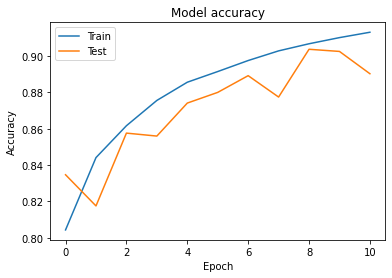

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

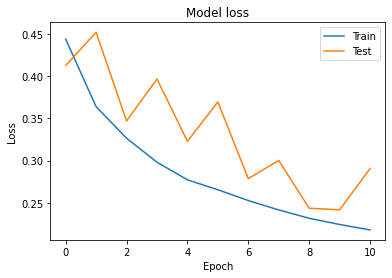

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [24]:
predictions = model.predict_generator(test_gen, steps = valid.shape[0], verbose = 1)

<ipython-input-24-903ba065d7aa>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps = valid.shape[0], verbose = 1)


16000/16000 [==============================] - 52s 3ms/step


In [25]:
pred = pd.DataFrame(predictions, columns=['no_tumor', 'has_tumor'])
pred.head()

,no_tumor,has_tumor
0,0.055699,0.944301
1,0.999945,0.000055
2,0.877603,0.122397
3,0.013808,0.986192
4,0.001231,0.998769


In [26]:
y_true = test_gen.classes
y_pred = pred['has_tumor']

In [27]:
print('ROC AUC Score = ',roc_auc_score(y_true, y_pred))

ROC AUC Score =  0.964506234375


In [28]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

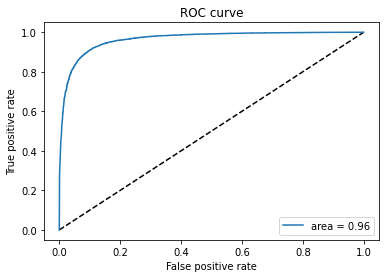

In [29]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.2f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

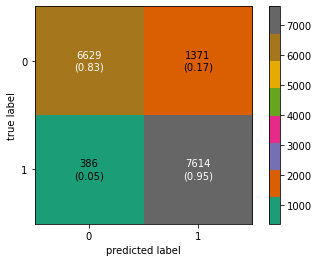

In [30]:
y_pred_binary = predictions.argmax(axis=1)
cm = confusion_matrix(y_true, y_pred_binary)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               cmap = 'Dark2')
plt.show()

In [31]:
shutil.rmtree("train_data")
shutil.rmtree("val_data")

## Prediction

In [32]:
os.mkdir("test_data")
os.mkdir("test_data/images")
for img in os.listdir("data/test"):
  source = os.path.join("data/test", img)
  destination = os.path.join("test_data/images", img)
  shutil.copyfile(source, destination)

In [33]:
test_gen = datagen.flow_from_directory("test_data",
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [34]:
predictions = model.predict_generator(test_gen, steps=len(os.listdir("data/test")), verbose=1)

   32/57458 [..............................] - ETA: 3:14

<ipython-input-34-a8623f2b3a69>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=len(os.listdir("data/test")), verbose=1)


57458/57458 [==============================] - 188s 3ms/step


In [35]:
pred = pd.DataFrame(predictions, columns=['no_tumor', 'has_tumor'])
pred.head()

,no_tumor,has_tumor
0,2.587591e-12,1.000000
1,3.100727e-03,0.996899
2,1.240965e-06,0.999999
3,1.165976e-03,0.998834
4,9.999932e-01,0.000007


In [36]:
pred["id"] = test_gen.filenames
pred["id"] = pred["id"].apply(lambda x: x.replace("images/","").replace(".tif",""))

In [37]:
pred = pred.rename(columns = {"has_tumor": "label"})
submission = pred[["id","label"]]
shutil.rmtree("test_data")

In [38]:
submission.to_csv("Submission.csv", index = False)